# **Introduction:**

This file serves to host an attempted Keras implementation of an Adaptive Neuro-Fuzzy Inference System (ANFIS).

**Date Created:** 22/01/2025

**Date Modified:** 28/01/2025

# **Import Packages:**

This section imports all the necessary packages for the ANFIS implementation.

In [1108]:
# import packages:
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import os
import time
from pickle import dump
from itertools import product
from keras.layers import Layer, Dense, Reshape, BatchNormalization, Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras import Input, Model

# **Function & Layer Definition:**

This section creates the necessary custom functions and layers for this ANFIS implementation within Keras. 

In [1109]:
# need to first define the initial layer -> the membership function layer:
class MembershipFunctionLayer(Layer):
    # constructor:
    def __init__(self, num_inputs, num_mfs, params = None, **kwargs):   # by including **kwargs, we allow for additional arguments from keras, like name or dtype
        super(MembershipFunctionLayer, self).__init__(**kwargs)         # we are subclassing from the keras layer -> telling the constructor to make our layer like a keras layer
        self.num_inputs = num_inputs            # define the number of inputs to the ANFIS 
        self.num_mfs = num_mfs                  # define the number of membership functions per input
        self.num_rules = num_mfs ** num_inputs  # the number of rules 

        # next is the initialization of the antecedent parameters:
        if params is not None:
            # initialize custom parameters defined by the user:
            self.mf_params = self.add_weight(
                shape=(self.num_inputs, self.num_mfs, 3),       # define their shape, (num_inputs, num_mfs, 3) as we have 3 params for a triangular mf
                initializer=tf.constant_initializer(params),    # initialize as constants from the provided array
                trainable=True,                                 # set to trainable
                name="Antecedent_Params",                       # assign them a name
                regularizer = regularizers.l2(0.01)             # regularization
            )
            print('Custom parameters have been set.')
        else:
            # initialize raw membership parameters:
            raw_params = self.add_weight(
                shape = (self.num_inputs, self.num_mfs, 3),                                 # define their shape, (num_inputs, num_mfs, 3) 
                initializer = tf.keras.initializers.RandomUniform(-1.0, 1.0, seed = 1234),   # initialize as a random, uniform distribution
                trainable = False,                                                          # set to trainable
                name = "Raw_Antecedent_Params",                                             # assign them a name 
            )

            # sort the parameters such that a <= b <= c:
            sorted_params = tf.sort(raw_params, axis = 1) + 0.1                 # sort such that a <= b <= c
            self.mf_params = self.add_weight(                       
                shape = (self.num_inputs, self.num_mfs, 3),                     # set the shape: (num_inputs, num_mfs, 3) as we have 3 params for a triangular mf
                initializer = tf.constant_initializer(sorted_params.numpy()),   # initialize as the sorted array of params
                trainable = True,                                               # set to trainable
                name = 'Antecedent_Params',                                     # assign them a name
                regularizer = regularizers.l2(0.01)                             # regularization
            )
            print('Random parameters have been set.')
 
    # function for visualizing the membership functions:
    def plot_mf(self, max_values, mf_names = None):
        # if the user did not provide names:
        if mf_names is None:
            mf_names = [f'MF {i + 1}' for i in range(self.num_mfs)]
        
        # make sure that the number of names matches the number of membership functions:
        if len(mf_names) != self.num_mfs:
            raise ValueError(f'Expected {self.num_mfs} membership functions, but got {len(mf_names)} instead.')
        
        # make sure that the provided max values match the number of membership functions:
        if len(max_values) != self.num_mfs:
            raise ValueError(f'Expected {self.num_mfs} max values, but got {len(max_values)} instead.') 
        
        # create linspace based on max values:
        input_range = {}
        for i in range(self.num_inputs):
            input_range[i] = np.linspace(0, max_values[i], 1000)

        # plot the mfs:
        for input_index in range(self.num_inputs):
            x_values = input_range[input_index]
            plt.figure(figsize = (12,8))

            # plot each mf for the selected input:
            for i in range(self.num_mfs):
                params = self.mf_params[input_index, i].numpy()
                a, b, c = params
                y_values = [np.maximum(0.0, np.minimum((x - a) / (b - a + 1e-6), (c - x) / (c - b + 1e-6))) for x in x_values]
                
                plt.plot(x_values, y_values, label = f'{mf_names[i]} - a: {a} | b: {b} | c: {c}')
            plt.title(f'Membership Functions for Input X{input_index + 1}')
            plt.xlabel('Input Value')
            plt.ylabel('Degree of Membership')
            plt.legend()
            plt.grid(True)
        plt.show()
    
    # need to define the call -> this is what gets executed by the layer:
    def call(self, inputs):
        # initialize list to hold membership values:
        membership_values = []
        # print(f"Input Shape in MembershipFunctionLayer: {inputs.shape}")

        # loop through each input:
        for i in range(self.num_inputs):
            # extract membership functions for the current input:
            input_mf_params = self.mf_params[i]  # symbolic tensor

            # compute membership values for all MFs for the current input:
            mf_values = []

            for j in range(self.num_mfs):
                a = input_mf_params[j, 0]
                b = input_mf_params[j, 1]
                c = input_mf_params[j, 2]

                mf_value = tf.maximum(
                    0.0,
                    tf.minimum(
                        (inputs[:, i] - a) / (b - a + 1e-6),
                        (c - inputs[:, i]) / (c - b + 1e-6),
                    ),
                )
                mf_values.append(mf_value)

            # stack MFs for this input
            membership_values.append(tf.stack(mf_values, axis = -1))

        # print(f"Output Shape in MembershipFunctionLayer: {tf.stack(membership_values, axis = 1).shape}")

        # stack all membership values (shape: batch_size, num_inputs, num_mfs)
        return tf.stack(membership_values, axis = 1)

# need to now define the second layer -> the firing strength layer:
class FiringStrengthLayer(Layer):
    # constructor:
    def __init__(self, num_inputs, num_mfs, **kwargs):
        super(FiringStrengthLayer, self).__init__(**kwargs)
        self.num_inputs = num_inputs
        self.num_mfs = num_mfs
        self.num_rules = num_mfs ** num_inputs

    # call function:
    def call(self, membership_values):

        # print(f"Input Shape in FiringStrengthLayer: {membership_values.shape}")

        # get batch size:
        batch_size = tf.shape(membership_values)[0]  

        # initialize firing strengths
        firing_strengths = tf.ones((batch_size, self.num_rules), dtype = tf.float32)    

        # generate all rule combinations:
        rules = list(product(range(self.num_mfs), repeat = self.num_inputs))  # example: [(0, 0, 0), (0, 0, 1), ...]

        # need to check each input, each mf combination, and multiply their values together:
        for rule_index, combination in enumerate(rules):
            # print(f'rule: {rule_index + 1} | combination: {combination}')
            rule_strength = tf.ones((batch_size, ), dtype = tf.float32)

            for input_index, mf_index in enumerate(combination):
                # print(f'input: {input_index + 1} | mf: {mf_index + 1}')

                # correctly extract the fuzzified values based on the combination index:
                rule_strength *= membership_values[:, input_index, mf_index]
                # print(f'strength: {rule_strength}')
            
            # update the firing strengths:
            rule_strength = tf.expand_dims(rule_strength, axis = -1)  # shape: (batch_size, 1)
            firing_strengths = tf.concat(
                [firing_strengths[:, :rule_index], rule_strength, firing_strengths[:, rule_index + 1:]],
                axis = 1,
            )

            tf.debugging.check_numerics(firing_strengths, "Firing strengths contain NaN or Inf")

        # print(f"Output Shape in FiringStrengthLayer: {firing_strengths.shape}")

        return firing_strengths

# need to now define the third layer -> the normalization layer:
class NormalizationLayer(Layer):
    # constructor:
    def __init__(self, num_inputs, num_mfs, **kwargs):
        super(NormalizationLayer, self).__init__(**kwargs)
        self.num_inputs = num_inputs
        self.num_mfs = num_mfs
        self.num_rules = num_mfs ** num_inputs

    # call function:
    def call(self, firing_strengths):
        # get batch size:
        batch_size = tf.shape(firing_strengths)[0]

        # print(f"Input Shape in NormalizationLayer: {firing_strengths.shape}")

        # get total firing strength:
        total_strength = tf.reduce_sum(firing_strengths, axis = 1, keepdims = True)
        # print(f'total strength: {total_strength}')
        
        # normalize the firing strengths:
        normalized_strengths = firing_strengths / (total_strength + 1e-10)

        # print(f"Output Shape in FiringStrengthLayer: {normalized_strengths.shape}")

        return normalized_strengths

# need to now define the fourth layer -> the consequent layer:
class ConsequentLayer(Layer):
    # constructor:
    def __init__(self, num_inputs, num_mfs, **kwargs):
        super(ConsequentLayer, self).__init__(**kwargs)
        self.num_inputs = num_inputs
        self.num_mfs = num_mfs
        self.num_rules = num_mfs ** num_inputs

        # need to also initialize the consequent parameters:
        self.consequent_params = self.add_weight(
            shape = (self.num_rules, self.num_inputs + 1),
            initializer = tf.keras.initializers.RandomUniform(-1.0, 1.0, seed = 1234),
            trainable = True,
            name = 'Consequent_Params',
            regularizer = regularizers.l2(0.05)    
        )

    # call function:
    def call(self, input_list):
        
        # inputs are a list -> extract values:
        normalized_strengths, inputs = input_list

        # print(f"Input Shape in ConsequentLayer: {normalized_strengths.shape}")

        # get the batch size
        batch_size = tf.shape(normalized_strengths)[0]

        # add bias term to inputs: shape (batch_size, num_inputs + 1)
        inputs_with_bias = tf.concat([inputs, tf.ones((batch_size, 1), dtype=tf.float32)], axis = -1)

        # reshape normalized_strengths to (batch_size, num_rules, 1)
        normalized_strengths = tf.reshape(normalized_strengths, (batch_size, self.num_rules, 1))

        # get consequent parameters: shape (num_rules, num_inputs + 1)
        consequent_params = self.consequent_params  # already initialized as a weight

        # expand inputs_with_bias to match the rule axis: (batch_size, num_rules, num_inputs + 1)
        inputs_with_bias_expanded = tf.expand_dims(inputs_with_bias, axis = 1)

        # calculate the consequent for each rule
        consequents = tf.reduce_sum(normalized_strengths * inputs_with_bias_expanded * consequent_params, axis = 2)

        tf.debugging.check_numerics(consequent_params, "Consequent parameters contain NaN or Inf")

        # print(f"Output Shape in ConsequentLayer: {consequents.shape}")

        return consequents

# now can define the final layer -> the output layer:
class OutputLayer(Layer):
    # constructor:
    def __init__(self, num_inputs, num_mfs, **kwargs):
        super(OutputLayer, self).__init__(**kwargs)
        self.num_inputs = num_inputs
        self.num_mfs = num_mfs
        self.num_rules = num_mfs ** num_inputs

    # call function:
    def call(self, consequents):

        # print(f"Input Shape in OutputLayer: {consequents.shape}")

        output = tf.reduce_sum(consequents, axis = 1, keepdims = True)

        # print(f"Output Shape in OutputLayer: {output.shape}")

        return output

# define a custom function for building models:
def BuildAnfis(input_shape, num_inputs, num_mfs, rate, antecedent_params = None):
    # define the following global variables:
    global LOSS_FUNCTION
    global METRICS
    
    # define the inputs:
    inputs = Input(shape = input_shape)

    ### DEFINE MODEL ARCHITECTURE ###
    # add the membership layer:
    membership_layer_output = MembershipFunctionLayer(num_inputs = num_inputs, num_mfs = num_mfs, params = antecedent_params)(inputs)

    # # add a dense layer between 1 & 2:
    # dense1_output = Dense(128, activation = 'relu')(membership_layer_output)

    # firing layer:
    firing_layer_output = FiringStrengthLayer(num_inputs = num_inputs, num_mfs = num_mfs)(membership_layer_output)

    # normalization layer:
    normalization_layer_output = NormalizationLayer(num_inputs = num_inputs, num_mfs = num_mfs)(firing_layer_output)

    # consequent layer:
    consequent_layer_output = ConsequentLayer(num_inputs = num_inputs, num_mfs = num_mfs)([normalization_layer_output, inputs])

    # # add a dense layer between 4 & 5:
    # dense2_output = Dense(64, activation = 'relu')(consequent_layer_output)

    # output layer:
    output = OutputLayer(num_inputs = num_inputs, num_mfs = num_mfs)(consequent_layer_output)

    # create and compile the model:
    model = Model(inputs = inputs, outputs = output)
    model.compile(optimizer = Adam(learning_rate = rate), 
                  loss = LOSS_FUNCTION,
                  metrics = METRICS)

    print('Model compiled!')

    return model


# **Data Import & Processing:**

This section imports the required data and splits it into training, validation, and testing sets. From this, the model can be trained and its performance verified.

In [1110]:
# get the data path:
files_in_dir = os.listdir(os.getcwd())
data_path = os.path.join(os.getcwd(), files_in_dir[files_in_dir.index('V3_Data.csv')])

# load data based on data path:
df = pd.read_csv(data_path)
print('Data successfully loaded')

Data successfully loaded


Need to first split into features and labels:

In [1111]:
# split into X and Y:
x_data = df.drop(columns = 'Suitability')
y_data = df['Suitability']

Now the data can be split into training, validation, and testing sets:

In [1112]:
# split the data using train_test_split:
x_train, x_filler, y_train, y_filler = train_test_split(x_data, y_data, test_size = 0.2)
x_val, x_test, y_val, y_test = train_test_split(x_filler, y_filler, test_size = 0.5)

# get the split results:
print(f'There are {x_train.shape[0]} training examples')
print(f'There are {x_val.shape[0]} validation examples')
print(f'There are {x_test.shape[0]} testing examples\n')

There are 8000 training examples
There are 1000 validation examples
There are 1000 testing examples



Now we can scale the data. The data must be scaled using the same scaler used on the training set, to ensure that the model is consistent:

In [1113]:
# define a scaler:
scaler = StandardScaler()

# scale each set:
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

# save the scaler:
dump(scaler, open('scaler.pkl', 'wb'))

# **Model Parameter Definition**

This section define the parameters used in generating a model. 

In [1114]:
# define the following to be used in model generation:
num_inputs = 3
num_mfs = 3
max_values = np.array([10, 25, 50])
mf_names = ['Low', 'Medium', 'High']
params = np.array([
    [  # Parameters for input 1
        [0, 0, 6],
        [5/6, 5, 55/6],
        [4, 10, 10]
    ],
    [  # Parameters for input 2
        [0, 0 , 15],
        [25/12, 12.5, 275/12],
        [10, 25, 25]
    ],
    [  # Parameters for input 3
        [0, 0, 30],
        [25/6, 25, 275/6],
        [15, 50, 50]
    ]
])

# **Model Training:**

This section pertains to the training of the model. 

In [1115]:
# define loss function & metrics:
LOSS_FUNCTION = 'mse'
METRICS = ['mae', tf.keras.metrics.RootMeanSquaredError()]
batch_size = 32

# make model:
tf.keras.backend.clear_session()
model = BuildAnfis(input_shape = (3, ), num_inputs = num_inputs, num_mfs = num_mfs, rate = 1e-4)

# get the starting time:
train_start = time.time()

# define early stopping:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True)

# save the training values to the history structure:
history = model.fit(x_train, y_train,
                    epochs = 250,
                    batch_size = batch_size,
                    validation_data = [x_val, y_val],
                    callbacks = early_stopping)

# get the total training time:
train_time = time.time() - train_start

# print to user:
print(f'Training complete in {round(train_time, 3)} seconds')


Random parameters have been set.
Model compiled!
Epoch 1/250
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 22.6311 - mae: 4.3000 - root_mean_squared_error: 4.5643 - val_loss: 22.5899 - val_mae: 4.2931 - val_root_mean_squared_error: 4.5683
Epoch 2/250
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - loss: 22.6619 - mae: 4.3012 - root_mean_squared_error: 4.5788 - val_loss: 22.4079 - val_mae: 4.2809 - val_root_mean_squared_error: 4.5592
Epoch 3/250
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - loss: 22.2572 - mae: 4.2666 - root_mean_squared_error: 4.5452 - val_loss: 22.2330 - val_mae: 4.2673 - val_root_mean_squared_error: 4.5501
Epoch 4/250
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step - loss: 22.2893 - mae: 4.2747 - root_mean_squared_error: 4.5586 - val_loss: 22.0687 - val_mae: 4.2542 - val_root_mean_squared_error: 4.5416
Epoch 5/250
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 21.7850 - mae: 4.2283 - root_mean_squared_error: 4.5120 - val_loss: 21.9115 - val_mae: 4.2409 - val_root_mean_sq

Can now visualize the training results:

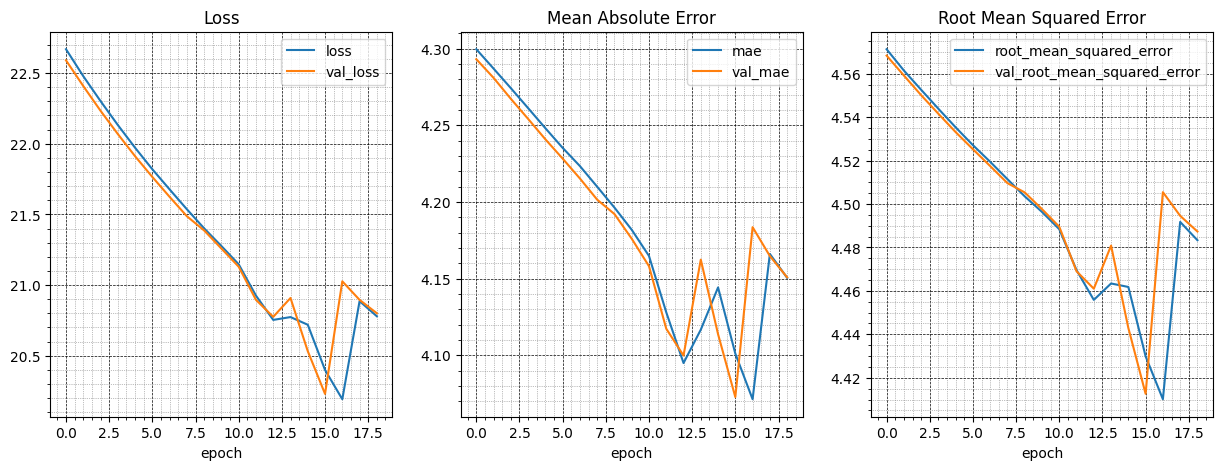

In [1116]:
# extract the history dictionary from the keras callback:
history_data = history.history

# drop the r2 scores from the history, getting a dictionary of just loss:
history_data.pop('r2_score', None)
history_data.pop('val_r2_score', None)

# list of metrics, text conversion, & halfway point:
metric_list = list(history_data.keys())
half = int(len(history_data.keys())/2)
metric2text = {'loss' : 'Loss',
               'mae' : 'Mean Absolute Error',
               'root_mean_squared_error': 'Root Mean Squared Error'
               }

# training history analysis:
plt.figure(figsize = (half * 5,5))

# iterate and plot the training values:
for index, metric in enumerate(metric_list[:half]):
    training_metric = metric
    validation_metric = metric_list[index + half]

    plt.subplot(1, half, index + 1)
    plt.plot(history_data[training_metric], label = training_metric)
    plt.plot(history_data[validation_metric], label = validation_metric)
    plt.xlabel('epoch')
    plt.legend(loc = 'upper right')
    plt.minorticks_on()
    plt.grid(which = 'major', color = 'black', linestyle = '--', linewidth = 0.5)
    plt.grid(which = 'minor', color = 'gray', linestyle = ':', linewidth = 0.5)
    plt.title(f'{metric2text[training_metric]}')

# **Utilize the Model:**

The model can now be used for predictions since it has been trained. The goal of this is to see the accuracy of the model in prediction, visualize the errors, and test the generalization of the model.

In [1117]:
# need to get the test metrics through model evaluation:
test_loss, test_mae, test_rmse = model.evaluate(x_test, y_test)

# need to get the predictions of the model:
pred_start = time.time()
y_pred = model.predict(x_test)
pred_time = time.time() - pred_start

# get the R2 score:
test_r2 = r2_score(y_test, y_pred)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step - loss: 19.5770 - mae: 4.0372 - root_mean_squared_error: 4.3366
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step 


Check the memory consumption:

In [1118]:
# import memory tracking functionalities:
import psutil

# get process ID:
process = psutil.Process(os.getpid())

# get memory before and after prediction:
mem_before = process.memory_info().rss / 1024 ** 2
y_pred = model.predict(x_test)
mem_after = process.memory_info().rss / 1024 ** 2

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


# **Model Results:**

This section serves to visualize the entirety of the results from testing the model. The metrics that are visualized are:

* MSE in testing
* MAE in testing
* RMSE in testing
* $R^{2}$ in testing
* Memory consumption of model 
* Prediction time of model
* Actual vs. Predicted curve of model
* Histogram of prediction errors

In [1119]:
# print model parameters to user:
print(f'test MSE was: {test_loss}\n',
      f'test MAE was: {test_mae}\n', 
      f'test RMSE was: {test_rmse}\n',
      f'test r2 score was: {test_r2}\n',
      f'memory used was: {round((mem_after - mem_before), 32)} MB\n',
      f'prediction time was: {round(pred_time, 3)} seconds')

test MSE was: 19.417274475097656
 test MAE was: 4.007195949554443
 test RMSE was: 4.319516658782959
 test r2 score was: -7.254026039730428
 memory used was: 0.01171875 MB
 prediction time was: 0.758 seconds


Scatter plot analysis of model:

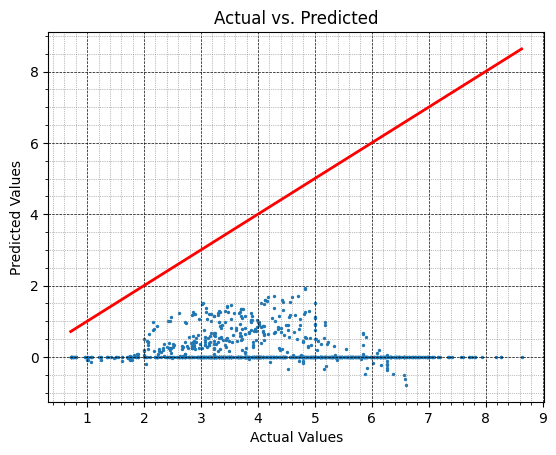

In [1120]:
# scatter plot analysis:
plt.figure()
plt.scatter(y_test, y_pred, s = 2)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color = 'red', lw = 2)

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted')

plt.grid(which = 'major', color = 'black', linestyle = '--', linewidth = 0.5)
plt.grid(which = 'minor', color = 'gray', linestyle = ':', linewidth = 0.5)
plt.minorticks_on()

Histogram of prediction errors:

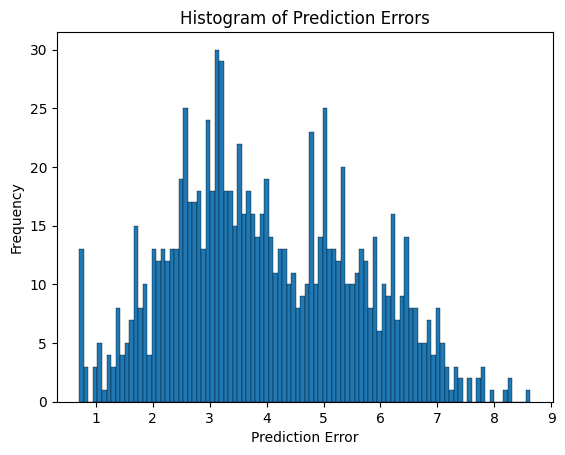

In [1121]:
# histogram analysis:
y_test = np.array(y_test).reshape(-1, 1)
error = y_test - y_pred

plt.figure()
plt.hist(error, bins = 100, edgecolor = 'black', linewidth = 0.25)

plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')

plt.show()

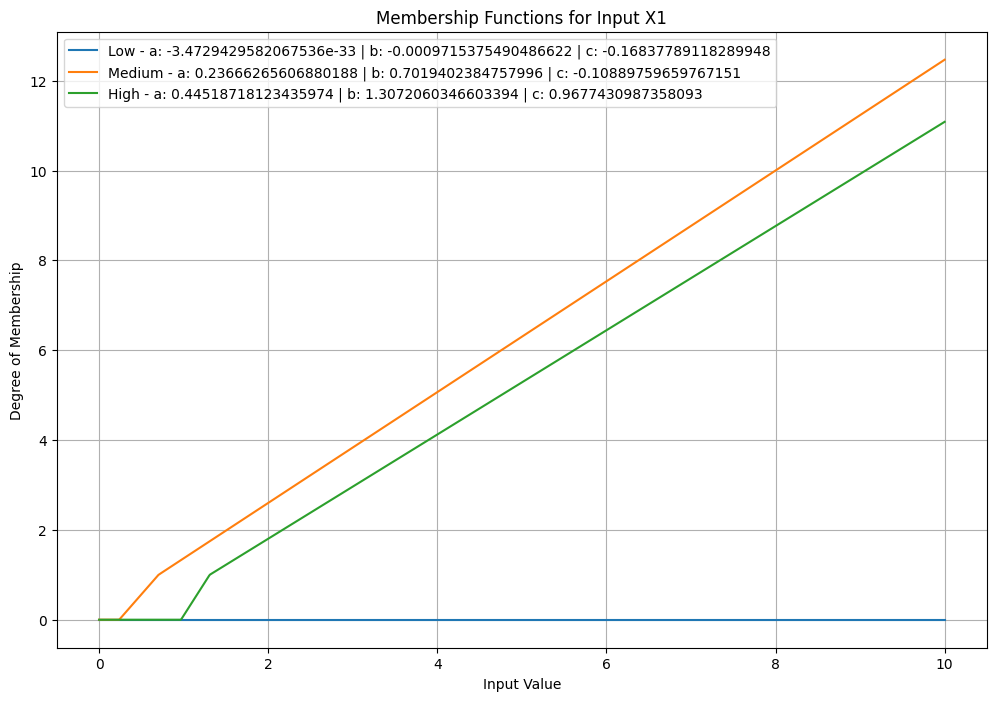

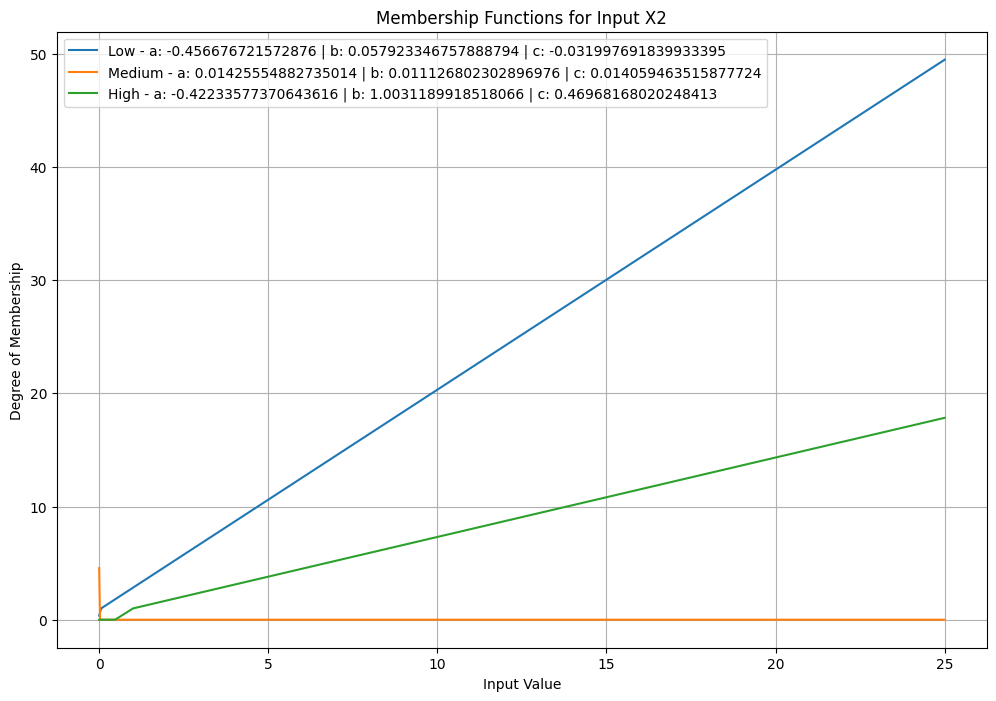

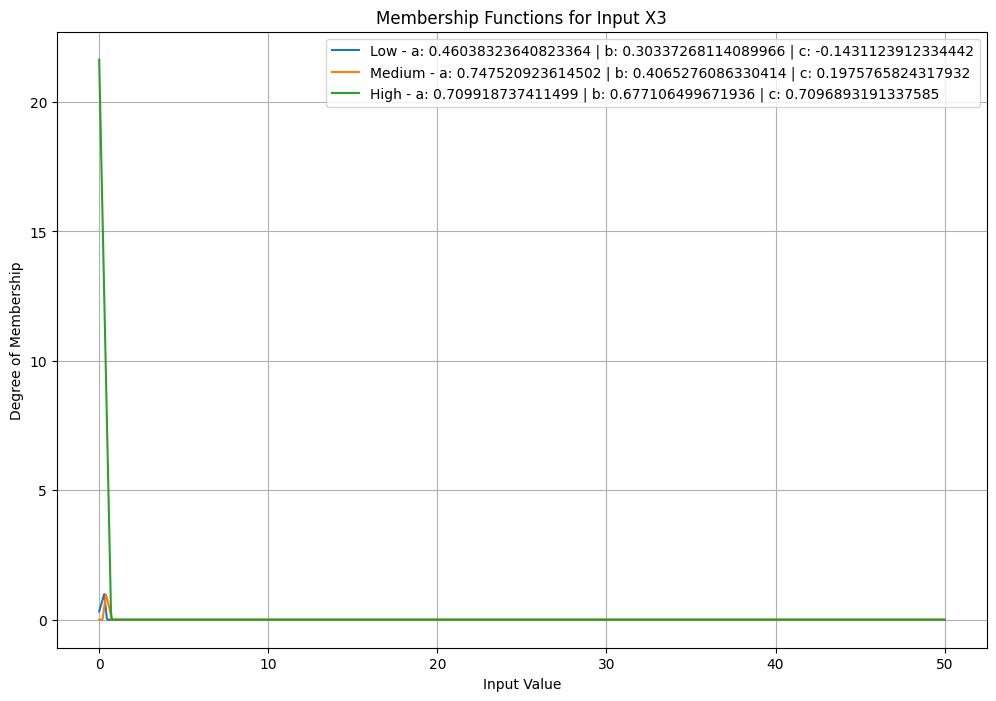

In [1122]:
# check the membership functions:
model.layers[1].plot_mf(max_values = max_values, mf_names = mf_names)